In [1]:
import pyspark.sql.functions as func
from pyspark.sql.types import IntegerType, StructType, StructField, StringType, FloatType
import math
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer
from pyspark.sql import SparkSession, DataFrame, Window, Row
from typing import Optional
import matplotlib.pyplot as plt

In [2]:
spark = (SparkSession.builder
                     .appName('Recommendations')
                     .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer")
                     .config("spark.kryoserializer.buffer.max", "2047m")
                     .config("spark.driver.memory", "15g")
                     .getOrCreate()
          )

# Set Hadoop configurations to use the service account JSON key
# sc = spark.sparkContext
# sc._jsc.hadoopConfiguration().set("fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem")
# sc._jsc.hadoopConfiguration().set("fs.gs.auth.service.account.enable", "true")
# sc._jsc.hadoopConfiguration().set("fs.gs.auth.service.account.json.keyfile", f"../keys/{json_key}")

24/04/27 21:22:16 WARN Utils: Your hostname, codespaces-b70f2a resolves to a loopback address: 127.0.0.1; using 172.16.5.4 instead (on interface eth0)
24/04/27 21:22:16 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/27 21:22:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
def preprocessing_business(spark,
                           city_name:str ='Philadelphia',
                           category:str = 'restaurant',
                           min_star_rating: Optional[int]= None,
                           min_review_count:int =10):

    df = spark.read.csv('./dataset_business.csv', header=True)
    df_filter = df.filter(
        (func.col('is_open')==1) &
        (func.lower(func.col('city'))== city_name.lower()) &
        (func.lower(func.col('categories')).contains(category.lower())) &
        (func.col('review_count') >= min_review_count)
    )
    if min_star_rating is not None:
        df_filter = df_filter.filter(func.col('stars') >= min_star_rating)

    df_select = df_filter.select(
        func.col('business_id'),
        func.col('categories'),
        func.col('name'),
        func.col('review_count'),
        func.col('stars').alias('business_stars')
    )

    string_indexer = StringIndexer(inputCol='business_id', outputCol='business_id_encode')
    model = string_indexer.fit(df_select)
    city_business_num_id = model.transform(df_select)

    # Convert encoded business_id to integer type
    city_business_num_id = city_business_num_id.withColumn(
        'business_id_encode',
        func.col('business_id_encode').cast(IntegerType())
    )

    return city_business_num_id

In [4]:
def preprocess_review(spark,
                      min_review_count: int = 10,
                      min_star_rating: Optional[int] = None,
                      ) -> DataFrame:

    df_reviews = spark.read.json('./slim_review.json')

    # Group by user_id to calculate review counts per user
    df_user_review_counts = df_reviews.groupBy("user_id").agg(
        func.count("review_id").alias("user_review_count")
    ).filter(func.col("user_review_count") >= min_review_count)

    # Join back to the original reviews to filter users by their review counts
    df_filtered_reviews = df_reviews.join(
        df_user_review_counts, "user_id"
    )

    # Optionally filter by star rating
    if min_star_rating is not None:
        df_filtered_reviews = df_filtered_reviews.filter(
            func.col("stars") >= min_star_rating
        )

    # Select and rename columns to match the SQL query
    df_final = df_filtered_reviews.select(
        func.col("user_id"),
        func.col("business_id"),
        func.col("date"),
        func.col("review_id"),
        func.col("stars").alias("user_stars"),
        func.col("text").alias("user_reviews")
    )

    # Encode the user_id using StringIndexer
    string_indexer = StringIndexer(inputCol='user_id', outputCol='user_id_encode')
    model = string_indexer.fit(df_final)
    user_reviews_num_id = model.transform(df_final)

    # Convert encoded user_id to integer type
    user_reviews_num_id = user_reviews_num_id.withColumn(
        'user_id_encode',
        func.col('user_id_encode').cast(IntegerType())
    )

    return user_reviews_num_id

In [5]:
reviews = preprocess_review(spark=spark)
businesses = preprocessing_business(spark=spark)

business_user_review = reviews.join(businesses,
                                    on='business_id',
                                    how='inner')

In [6]:
businesses.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: string (nullable = true)
 |-- business_stars: string (nullable = true)
 |-- business_id_encode: integer (nullable = true)



In [7]:
reviews.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- user_stars: long (nullable = true)
 |-- user_reviews: string (nullable = true)
 |-- user_id_encode: integer (nullable = true)



In [8]:
reviews.show(10)

+--------------------+--------------------+-------------------+--------------------+----------+--------------------+--------------+
|             user_id|         business_id|               date|           review_id|user_stars|        user_reviews|user_id_encode|
+--------------------+--------------------+-------------------+--------------------+----------+--------------------+--------------+
|-Cw2rJx6v8gHgWOBX...|6_T2xzR74JqGCTPef...|2011-08-16 00:08:57|bZBN5lFvhz1UebCmj...|         5|FRESH FRESH FRESH...|          5444|
|-Cw2rJx6v8gHgWOBX...|PP3BBaVxZLcJU54uP...|2011-08-29 15:15:25|iZGzgccv0AXwEidKw...|         4|How could you not...|          5444|
|-Cw2rJx6v8gHgWOBX...|hX_8ZUmIqWFWzjdiP...|2012-01-20 19:50:08|WlxKsYqEtaGYnAdoT...|         4|Ordered the pigno...|          5444|
|-Cw2rJx6v8gHgWOBX...|ntiIq1FNqduOyyowM...|2011-08-16 00:10:12|rYV5irskfexITtv-p...|         5|affordable and ve...|          5444|
|-Cw2rJx6v8gHgWOBX...|IWHdx0NhDKADkGOgX...|2011-08-16 01:03:23|MveqEVKQQYy-V

In [9]:
business_user_review.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- user_stars: long (nullable = true)
 |-- user_reviews: string (nullable = true)
 |-- user_id_encode: integer (nullable = true)
 |-- categories: string (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: string (nullable = true)
 |-- business_stars: string (nullable = true)
 |-- business_id_encode: integer (nullable = true)



In [10]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import StopWordsRemover, RegexTokenizer, HashingTF, IDF, Normalizer
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors

In [11]:
def train_test_split(
    df_reviews: DataFrame,
    train_perc: int = 0.7) -> DataFrame:
    
    #Random shuffle
    shuffled_final = df_reviews.orderBy(func.rand(42))

    # Define window specification partitioned by the user_id column and corresponding row number
    window_spec = Window.partitionBy("user_id").orderBy("user_id")
    final_reviews_with_row_number = shuffled_final.withColumn("row_number", func.row_number().over(window_spec))

    # Calculate the total number of rows for each user
    user_counts = final_reviews_with_row_number.groupBy("user_id").count()

    # Calculate the number of rows to include in the training set for each user
    user_test_counts = user_counts.withColumn("test_count", (func.col("count") * (1-train_perc)).cast("int"))

    #Join row number data with test count
    final_with_test_counts = final_reviews_with_row_number.join(user_test_counts, "user_id", "inner")

    # Create training and testing DataFrames for each user
    train_data = final_with_test_counts.filter(func.col("row_number") <= (func.col("count") - func.col("test_count")))
    test_data = final_with_test_counts.filter(func.col("row_number") > (func.col("count") - func.col("test_count")))

    # Drop the intermediate columns
    train_data = train_data.drop("row_number", "count", "test_count")
    test_data = test_data.drop("row_number", "count", "test_count")
    
    return train_data, test_data

In [12]:
(train, test) = train_test_split(df_reviews=business_user_review)

In [13]:
# initial train test datasets size
train.count(), test.count()

24/04/27 21:22:31 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


(142445, 56510)

In [14]:
# model = cv.fit(train)

In [15]:
def rank_to_rmse_curve(rank_limits=(50,200)):
    
    ranks = [r for r in range(rank_limits[0], rank_limits[1], 10)]
    
    evaluator = RegressionEvaluator(
    metricName='rmse',
    labelCol='user_stars',
    predictionCol='prediction'
    )
    
    rmses = []
    for rank in ranks:
        als = ALS(userCol='user_id_encode',
          itemCol='business_id_encode',
          ratingCol='user_stars',
          coldStartStrategy='drop',
          nonnegative=True,
          rank=rank,
          regParam=0.19,
          seed=42
          )
        model = als.fit(train)
        predictions = model.transform(test)
        rmse = evaluator.evaluate(predictions)
        rmses.append(rmse)
        
    plt.plot(ranks, rmses)
    plt.xlabel('ranks')
    plt.ylabel('RMSE')
    plt.title('Ranks vs RMSE for ALS model')
    plt.show()

24/04/27 21:22:43 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/04/27 21:22:43 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


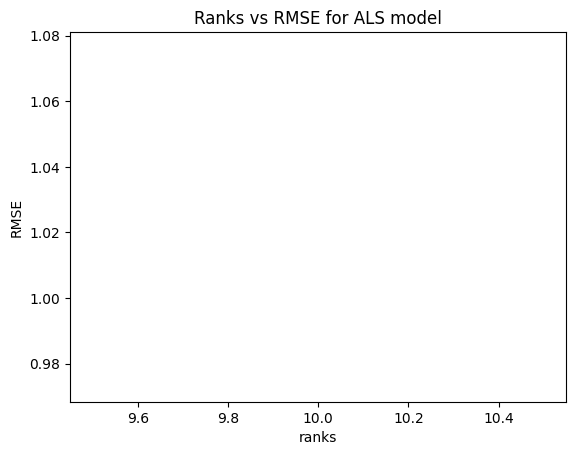

In [16]:
rank_to_rmse_curve(rank_limits=(10,20))

In [17]:
als = ALS(userCol='user_id_encode',
          itemCol='business_id_encode',
          ratingCol='user_stars',
          coldStartStrategy='drop',
          nonnegative=True,
          rank=110,
          regParam=0.19,
          seed=42
          )

# make ALS model
# best rank: 110
# best regParam: 0.19

evaluator = RegressionEvaluator(
    metricName='rmse',
    labelCol='user_stars',
    predictionCol='prediction'
)

In [18]:
als_params = ParamGridBuilder().addGrid(als.rank, [12,13,14]) \
                               .addGrid(als.regParam, [0.17,0.18,0.19]) \
                               .build()        
cv = CrossValidator(
        estimator=als,
        estimatorParamMaps=als_params,
        evaluator=evaluator
    )

In [19]:
# recombine train and test
df_combine = train.unionByName(test)

In [20]:
model = als.fit(df_combine)
predictions = model.transform(test)
rmse = evaluator.evaluate(predictions)
# print(rmse)

In [21]:
user_rec = model.recommendForAllUsers(10)
# https://github.com/apache/spark/blob/master/examples/src/main/python/ml/als_example.py

In [22]:
# user_rec.count()

In [23]:
# test.printSchema()

In [24]:
# filtered_user_rec = user_rec.withColumn(
#     "filtered_recommendations",
#     func.expr("filter(recommendations, item -> item.rating > 4.0)")
# )

# non_empty_user_rec = filtered_user_rec.filter(
#     func.size(func.col("filtered_recommendations")) > 0
# )
# # Display the filtered results
# non_empty_user_rec.select("user_id_encode", "filtered_recommendations").show(10, truncate=False)

In [25]:
# test.filter((func.col('user_id_encode')==928) & (func.col('business_id_encode')==1209)).show()

In [26]:
# preprocess_review(spark=spark).show(5)

In [27]:
# preprocessing_business(spark=spark, min_review_count=3).show(5)

In [28]:
# process text reviews by user
def review_text_processing(df_train: DataFrame,
                           df_test: DataFrame,
                           reivew_col: str = 'user_reviews',
                           rating_cut_off: float = 0) -> DataFrame:

    df_train_lower = df_train.withColumn(reivew_col, func.lower(reivew_col))
    df_test_lower = df_test.withColumn(reivew_col, func.lower(reivew_col))
    
    
    # aggregate reviews by business in train
    df_train_agg = df_train_lower.groupBy('business_id', 'name').agg(
        func.concat_ws(' ', func.collect_list('user_reviews')).alias(reivew_col),
        func.mean('business_stars').alias('business_stars'),
    ).filter(
        func.col('business_stars') >= rating_cut_off
    )
    # aggregate reviews by user
    df_test_agg = df_test_lower.groupBy('user_id').agg(
        func.concat_ws(' ', func.collect_list('user_reviews')).alias(reivew_col)
    )
    # Define the regex tokenizer
    regex_tokenizer = RegexTokenizer(
        inputCol=reivew_col,
        outputCol='words',
        pattern="\\W"  # This regex splits the text at any non-word character
    )
    # Define the stopwords remover
    stopwords_remover = StopWordsRemover(inputCol='words', outputCol='filtered_words')

    # tf-idf
    hashing_tf = HashingTF(inputCol='filtered_words',
                           outputCol='raw_features', numFeatures=100)
    idf = IDF(inputCol='raw_features', outputCol='features')
    # Define the pipeline with the stages
    pipeline = Pipeline(stages=[regex_tokenizer, stopwords_remover, hashing_tf, idf])

    # Fit the pipeline to the data and transform the data
    model = pipeline.fit(df_train_agg)
    train_transformed = model.transform(df_train_agg)
    test_transformed = model.transform(df_test_agg)

    # remove extra columns
    train_transformed = train_transformed.drop(
        'date',
        # 'user_id',
        'categories',
        'review_count',
        # 'business_id',
        'words',
        'filtered_words',
        'raw_features',
        reivew_col
    )
    test_transformed = test_transformed.drop(
        'date',
        # 'user_id',
        'categories',
        'review_count',
        # 'business_id',
        'words',
        'filtered_words',
        'raw_features',
        reivew_col
    )

    for col in train_transformed.columns:
        if col != 'features':
            train_transformed = train_transformed.withColumnRenamed(col, 'train_'+col)

    for col in test_transformed.columns:
        if col != 'features':
            test_transformed = test_transformed.withColumnRenamed(col, 'test_'+col)

    return train_transformed, test_transformed

In [29]:
# df_train.show(5)

In [30]:
# def cosine_similarity(features1, features2):
#     return float(float(features1.dot(features2)) / (Vectors.norm(features1, 2) * Vectors.norm(features2, 2)))

# cosine_similarity_udf = func.udf(cosine_similarity, FloatType())

# def cosine_recommendation(train_transformed: DataFrame,
#                           test_transformed: DataFrame,
#                           sim_cut_off: float = 0.5) -> DataFrame:

#     normalizer = Normalizer(inputCol='features', outputCol='norm_features', p=2.0)
#     train_normalized = normalizer.transform(train_transformed).withColumnRenamed("norm_features", "train_norm_features")
#     test_normalized = normalizer.transform(test_transformed).withColumnRenamed("norm_features", "test_norm_features")


#     # Perform a Cartesian join to calculate cosine similarity between every test and train pair
#     cartesian_df = test_normalized.crossJoin(func.broadcast(train_normalized))
    
#     result_df = cartesian_df.withColumn(
#         'similarity',
#         cosine_similarity_udf(cartesian_df['test_norm_features'], cartesian_df['train_norm_features'])
#     )
#     result_df = result_df.filter(
#         func.col('similarity') >= sim_cut_off
#     )
    
#     # Define window spec
#     windowSpec = Window.partitionBy("test_user_id").orderBy(func.col("similarity").desc())

#     # Apply window function to rank similarities and filter top N
#     result_df = result_df.withColumn("rank", func.row_number().over(windowSpec)).filter(func.col("rank") <= 5)

#     return result_df

In [31]:
def cosine_similarity(v1, v2):
    dot_product = sum(x * y for x, y in zip(v1, v2))
    norm1 = math.sqrt(sum(x**2 for x in v1))
    norm2 = math.sqrt(sum(y**2 for y in v2))
    if norm1 * norm2:
        return dot_product / (norm1 * norm2)
    else:
        return 0.0

def cosine_recommendation(train_transformed: DataFrame, test_transformed: DataFrame, sim_cut_off: float = 0.5) -> DataFrame:
    normalizer = Normalizer(inputCol='features', outputCol='norm_features')
    train_normalized = normalizer.transform(train_transformed)
    test_normalized = normalizer.transform(test_transformed)

    # Convert DataFrames to RDDs for manual vector handling
    train_rdd = train_normalized.rdd.map(lambda x: (x['train_business_id'], x['norm_features'].toArray()))
    test_rdd = test_normalized.rdd.map(lambda x: (x['test_user_id'], x['norm_features'].toArray()))

    # Perform Cartesian product and calculate cosine similarity
    result_rdd = test_rdd.cartesian(train_rdd).map(lambda x: Row(
        test_user_id=x[0][0],
        train_business_id=x[1][0],
        similarity=float(cosine_similarity(x[0][1], x[1][1]))  # Cast to float here
    ))

    # Define schema explicitly for DataFrame conversion
    schema = StructType([
        StructField("test_user_id", StringType(), False),
        StructField("train_business_id", StringType(), False),
        StructField("similarity", FloatType(), False)
    ])

    # Convert RDD back to DataFrame using the defined schema
    result_df = spark.createDataFrame(result_rdd, schema)

    # Filter by similarity cutoff and apply window function to get top 5 results
    windowSpec = Window.partitionBy("test_user_id").orderBy(func.col("similarity").desc())
    result_df = result_df.filter(func.col("similarity") >= sim_cut_off).withColumn("rank", func.row_number().over(windowSpec)).filter(func.col("rank") <= 10)

    return result_df

In [32]:
def get_hit_rate(ground_truth_df, # test data
                 recommended_df, # result_df
                 user_col, # user_id
                 item_col # business_id
                 ):
    # Join ground truth and recommended items on user ID
    joined_df = ground_truth_df.join(recommended_df, on=user_col)

    # Filter to count hits (correct recommendations) for each user
    hits_df = joined_df.filter(func.col("recommended_" + item_col) == func.col(item_col)) \
                       .select(user_col).distinct()

    # Count the distinct users with at least one correct recommendation
    users_with_hits = hits_df.select(func.countDistinct(user_col)).collect()[0][0]

    # Count the total number of distinct users for whom recommendations were made
    total_users = recommended_df.select(func.countDistinct(user_col)).collect()[0][0]

    # Calculate total hit rate
    total_hit_rate = users_with_hits / total_users

    return total_hit_rate

def get_recall(ground_truth_df,
               recommended_df,
               user_col,
               item_col):
    # Join ground truth and recommended items on user ID
    joined_df = ground_truth_df.join(recommended_df, on=user_col)

    # Count the number of relevant recommended items and total relevant items for each user
    relevant_recommended_items = joined_df.filter(func.col("recommended_"+item_col) == func.col(item_col))
    total_relevant_items = ground_truth_df.groupBy(user_col).count()

    # Compute recall for each user
    recall_df = relevant_recommended_items.groupBy(user_col).count().withColumnRenamed("count", "relevant_count") \
        .join(total_relevant_items, on=user_col)
    recall_df = recall_df.withColumn("recall", func.col("relevant_count") / func.col("count"))

    # Average recall across all users
    average_recall = recall_df.selectExpr("avg(recall)").collect()[0][0]

    return average_recall

In [33]:
df_train, df_test = review_text_processing(
                        df_train=train,
                        df_test=test,
                        rating_cut_off=4)  # only 4-star or above restaurant will be recommended

In [34]:
df_test.printSchema()

root
 |-- test_user_id: string (nullable = true)
 |-- features: vector (nullable = true)



In [35]:
result_df = cosine_recommendation(train_transformed=df_train, test_transformed=df_test, sim_cut_off=0.7)

In [36]:
# result_df.select("test_user_id_encode").distinct().count()

In [37]:
predictions.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- user_stars: long (nullable = true)
 |-- user_reviews: string (nullable = true)
 |-- user_id_encode: integer (nullable = true)
 |-- categories: string (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: string (nullable = true)
 |-- business_stars: string (nullable = true)
 |-- business_id_encode: integer (nullable = true)
 |-- prediction: float (nullable = false)



In [38]:
# calculate hit rate and recall for ALS
als_threshold_rating = 4
filtered_predictions = predictions.filter(predictions["prediction"] >= als_threshold_rating).withColumnRenamed("business_id", "recommended_business_id")

recall_als = get_recall(test, filtered_predictions, "user_id", "business_id")
hit_rate_als = get_hit_rate(test, filtered_predictions, "user_id", "business_id")
print("Root Mean Squared Error (RMSE):", rmse)
print("Avg Recall:", recall_als)
print("Hit Rate:", hit_rate_als)

example_rec = filtered_predictions.filter(func.col('user_id')=='-AwZjQNFpCqc0bVNNyBqwg').select('Name', 'prediction', )
example_rec.show(20, truncate=False)

24/04/27 21:23:37 WARN DAGScheduler: Broadcasting large task binary with size 1045.3 KiB


Root Mean Squared Error (RMSE): 0.7636999948212142
Avg Recall: 0.5416377773486272
Hit Rate: 1.0
+-----------------------------+----------+
|Name                         |prediction|
+-----------------------------+----------+
|Southwark Restaurant         |4.221628  |
|Meskerem Ethiopian Restaurant|4.190869  |
|Southwark Restaurant         |4.221628  |
+-----------------------------+----------+



In [39]:
result_df = result_df.withColumnRenamed('test_user_id', 'user_id').withColumnRenamed('train_business_id', 'recommended_business_id')

In [40]:
result_df.printSchema()

root
 |-- user_id: string (nullable = false)
 |-- recommended_business_id: string (nullable = false)
 |-- similarity: float (nullable = false)
 |-- rank: integer (nullable = false)



In [41]:
# result_df.count()

In [42]:
# calculate hit rate and recall for content based
#Define ground truth and recommended df
# Calculate recall
# recall = get_recall(test, result_df, "user_id", "business_id")
# hit_rate = get_hit_rate(test, result_df, "user_id", "business_id")
# print("Avg Recall:", recall)
# print("Hit Rate:", hit_rate)

In [43]:
df_combine.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- user_stars: long (nullable = true)
 |-- user_reviews: string (nullable = true)
 |-- user_id_encode: integer (nullable = true)
 |-- categories: string (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: string (nullable = true)
 |-- business_stars: string (nullable = true)
 |-- business_id_encode: integer (nullable = true)



In [44]:
result_df.printSchema()

root
 |-- user_id: string (nullable = false)
 |-- recommended_business_id: string (nullable = false)
 |-- similarity: float (nullable = false)
 |-- rank: integer (nullable = false)



In [46]:
joined_df = result_df.filter(func.col("user_id") == '-AwZjQNFpCqc0bVNNyBqwg') \
    .join(df_combine, result_df.recommended_business_id == df_combine.business_id) \
    .select(result_df.user_id, result_df.recommended_business_id, df_combine.name, result_df.similarity, result_df.rank)

# Selecting distinct rows based on recommended_business_id to ensure uniqueness
unique_business_ids = joined_df.select("recommended_business_id", "name", 'similarity').distinct()

# Show the results with distinct recommended_business_id
unique_business_ids.show(truncate=False)

+-----------------------+----------------------+----------+
|recommended_business_id|name                  |similarity|
+-----------------------+----------------------+----------+
|85e8Uyn8tIyEZCqBP80rqA |Lolita                |0.8909454 |
|dVC2Rg_BGW3XOIlvEFxh9g |DAWA Sushi & Ramen Bar|0.8915551 |
|ZKPrXH_GNW_AtZ31tP3NmA |White Dog Cafe        |0.8895499 |
|73UjNbSoQjQAOS45rcihFg |Cantina Dos Segundos  |0.8914666 |
|q9WA6PqTLnB78DWPu5YJ5A |Perla                 |0.8955451 |
|j6usntbtSzFyuwx4n2mn1g |Las Bugambilias       |0.8985427 |
|0K4RwxdAcViifyU3Htzxww |Southwark Restaurant  |0.89000714|
|ILvJAuSP0sYWJKAQ-Goh4Q |Kensington Quarters   |0.8907577 |
|7mpYTDb24SywNMRn3yeakQ |The Twisted Tail      |0.8910358 |
|kxKai8GE5oDMPevV7oxvbA |Tequilas Restaurant   |0.89200604|
+-----------------------+----------------------+----------+

